In [8]:
import os 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import checkpoints
import matplotlib.pyplot as plt
from tifffile import imread, imsave
import torch
import torch.utils.data as dt

In [9]:
os.chdir('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP-JAX')
# os.chdir(r'C:\Users\ankit\Desktop\Msc AIML\msc-project\GAP-JAX')
from gap_jax.BinomDataset_JAX import BinomDataset
from  gap_jax.GAP_JAX_Trainer import Trainer, TrainState
from gap_jax.GAP_UNET_ResBlock_JAX import UN

In [10]:
data = np.concatenate((imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/trainingDataGT.tif'), imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testDataGT.tif')))

In [11]:
print(data.shape)

(2048, 512, 512)


In [12]:
def psnrToString(inp):
    if inp < 0:
        return 'm'+str(-inp)
    else:
        return str(inp)

minpsnr = -40
maxpsnr = -5

name = 'm40tom5-256x256-jax-base-v4-pls'
# CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/jax/'
# CHECKPOINT_PATH  = "C:\\Users\\ankit\\Desktop\\Msc AIML\\Data\\checkpoints\\models\\jax\\windows\\"
CHECKPOINT_PATH = '/home/ankith/temp/test/'
CHECKPOINT_PATH, name

('/home/ankith/temp/test/', 'm40tom5-256x256-jax-base-v4-pls')

In [13]:
maxepochs = 30 # train longer for better results

# Create pytorch dataset
dataset = BinomDataset(data = data[:round(data.shape[0]*0.9)], windowSize = 256, minPSNR = minpsnr, maxPSNR = maxpsnr)
val_dataset = BinomDataset(data = data[round(data.shape[0]*0.9):], windowSize = 256, minPSNR = minpsnr, maxPSNR = maxpsnr)

# Create pytorch dataloader for training and validation sets
train_loader = dt.DataLoader(dataset, batch_size=4, shuffle=True, drop_last=True, pin_memory=False, num_workers=4, collate_fn= lambda batch: np.array(batch)) ## Changing the batch size from 32 to 16 to fit inside the gpu
val_loader = dt.DataLoader(val_dataset, batch_size=4, shuffle=False, drop_last=True,  pin_memory=False, num_workers=4, collate_fn= lambda batch: np.array(batch))

# img =  next(iter(val_loader))

# print(img.shape)

In [14]:
model = UN(channels = 1, levels=10, depth=6, start_filts=28, up_mode = 'transpose')

In [15]:
len(val_loader)

51

In [16]:
maxepochs = 25 # train longer for better results

trainer = Trainer(root_dir= os.path.join(CHECKPOINT_PATH, name),
                  gradient_clip_val=0.5,
                  epochs= maxepochs,
                  dataloader= train_loader,
                  model = model)


Using Dummy data of shape : (1, 256, 256, 1)


GPU detected with 1 Device(s).


In [28]:
import warnings
warnings.filterwarnings("ignore", message="os.fork()")
warnings.filterwarnings("ignore", message="Unable to register cuDNN factory")
warnings.filterwarnings("ignore", message="Unable to register cuFFT factory")
warnings.filterwarnings("ignore", message="Unable to register cuBLAS factory")
warnings.filterwarnings("ignore", message="Difference at")

trainer.train_model(train_loader= train_loader,
                    val_loader= val_loader)

  0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/460 [00:00<?, ?it/s]


Train Avg Loss: -0.20266510546207428




Val Loss: -0.17047272622585297



Training:   0%|          | 0/460 [00:00<?, ?it/s]


Train Avg Loss: -0.2318219691514969


Val Loss: -0.18700194358825684



: 

In [39]:
name = 'm40tom5-256x256-jax-base-v5-exp-2'
CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/jax/'
# CHECKPOINT_PATH  = "C:\\Users\\ankit\\Desktop\\Msc AIML\\Data\\checkpoints\\models\\jax\\windows\\"
# CHECKPOINT_PATH = '/home/ankith/temp/test/'
CHECKPOINT_PATH, name

('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/jax/',
 'm40tom5-256x256-jax-base-v5-exp-2')

In [40]:
state_dict = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, name),
                                                    target=trainer.state.params)


In [41]:
state = TrainState.create(apply_fn=trainer.state.apply_fn,
                                       params=state_dict,
                                       tx=trainer.state.tx)

In [42]:
state.params # col 1 6 row 4.09239717e -- 4.25969213e-02 - 0.12077873 - -0.1373128

{'params': {'down_convs_0': {'DownConv-1': {'kernel': Array([[[[ 0.16479035,  0.05775022, -0.12258694, ...,  0.05989773,
              -0.06250944,  0.04175668],
             [ 0.08867583, -0.06688447, -0.04664797, ..., -0.01618707,
              -0.11639915, -0.04667169],
             [ 0.07240298,  0.01338829, -0.03126397, ..., -0.0445404 ,
              -0.00154301,  0.0398393 ],
             ...,
             [ 0.09651384,  0.12460996,  0.16735475, ...,  0.00271535,
              -0.02913156, -0.01655326],
             [-0.03136456, -0.03054362, -0.1627985 , ...,  0.05627134,
               0.10652882, -0.00426171],
             [ 0.15585493, -0.09985821, -0.10925659, ...,  0.02198127,
               0.00519359, -0.07279779]],
    
            [[ 0.00165791,  0.01874832,  0.10542191, ..., -0.07606976,
               0.09776906, -0.110161  ],
             [ 0.15039107, -0.19336998, -0.11148854, ...,  0.00443393,
               0.05401076,  0.08226734],
             [-0.01934248,  0.

In [14]:
trainer.load_model()

In [42]:
trainer.state.params

{'params': {'down_convs_0': {'conv1': {'kernel': Array([[[[ 0.05252371,  0.00856764, -0.1311924 , ..., -0.08108836,
              -0.02415212, -0.15023682],
             [-0.01530965,  0.08780311,  0.12329557, ...,  0.0119256 ,
               0.1086046 ,  0.02902851],
             [ 0.05993108, -0.03381776,  0.03470314, ...,  0.03025927,
              -0.1373128 ,  0.00089518],
             ...,
             [-0.01210879, -0.05462473, -0.12354404, ...,  0.03354293,
               0.09952995, -0.02905121],
             [-0.1464087 ,  0.03536003,  0.11657611, ...,  0.1563413 ,
               0.14615542, -0.10806041],
             [-0.11584789,  0.01133839,  0.02839683, ...,  0.01475234,
              -0.06618725, -0.1247691 ]],
    
            [[-0.04754927, -0.10504861, -0.14852586, ..., -0.13912779,
               0.07600798,  0.07265963],
             [-0.00807642,  0.09962226, -0.0226881 , ...,  0.09983715,
               0.03965093,  0.13966654],
             [-0.10851679, -0.05240

In [69]:
import orbax.checkpoint as ocp
orbax_checkpointer = ocp.PyTreeCheckpointer()
options = ocp.CheckpointManagerOptions(max_to_keep=2, create=True)
path = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/jax/m40tom5-256x256-jax-base-v4-exp-2orbax/'
checkpoint_manager = ocp.CheckpointManager(
    path, orbax_checkpointer, options)
step = checkpoint_manager.latest_step()
state = checkpoint_manager.restore(step)['model']

: 

In [68]:
state.apply_fn()

AttributeError: 'dict' object has no attribute 'apply_fn'

In [43]:
dataTest = imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testData.tif')[:1]     # to speed things up, we are only doing the first image
dataTestGT =imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testDataGT.tif')[:1]
dataTest.shape

(1, 512, 512)

In [65]:
for inp, gt in zip(dataTest, dataTestGT):
    inpT = jnp.expand_dims(inp.astype(np.float32), axis = -1)
    print(f'inpT shape {inpT[None].shape}')
    # inpT = inpT/inpT.sum()
    out = np.array(model.apply(state['model']['params'], inpT[None]))
    print(f'inp shape: {inp.shape}')
    print(f'out shape: {out.shape}')
    out = inp.sum() * out / out.sum()

    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))

    inp = inp/inp.mean()
    out = out/out.mean()
    gt = gt/gt.mean()
    vmax = np.percentile(gt,99)

    plt.figure(figsize=(7,7))
    plt.imshow(inpT[:, :, 0],vmin = 0, vmax = vmax, cmap = "inferno")
    plt.title('inp')
    plt.show()
    
    vmax = np.percentile(gt,99)
    plt.figure(figsize=(7,7))
    plt.imshow(out[0,:,:,0],vmin = 0, vmax = vmax, cmap = "inferno")
    plt.title('out')
    plt.show()
    
    vmax = np.percentile(gt,99)
    plt.figure(figsize=(7,7))
    plt.imshow(gt,vmin = 0,vmax = vmax, cmap = "inferno")
    plt.title('GT')
    plt.show()

   

inpT shape (1, 512, 512, 1)
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/ankith/anaconda3/envs/rsenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_76203/3949448955.py", line 5, in <module>
    out = np.array(model.apply(state['model']['params'], inpT[None]))
  File "/home/ankith/anaconda3/envs/rsenv/lib/python3.10/site-packages/jax/_src/traceback_util.py", line 179, in reraise_with_filtered_traceback
    return fun(*args, **kwargs)
  File "/home/ankith/anaconda3/envs/rsenv/lib/python3.10/site-packages/flax/linen/module.py", line 2252, in apply
    return apply(
  File "/home/ankith/anaconda3/envs/rsenv/lib/python3.10/site-packages/flax/core/scope.py", line 1101, in wrapper
    y = fn(root, *args, **kwargs)
  File "/home/ankith/anaconda3/envs/rsenv/lib/python3.10/site-packages/flax/linen/module.py", line 3032, in scope_fn
    return fn(module.clone(parent=scope, _deep_clone=True), *args, **kwar

In [45]:
out.min(), inp.min(), gt.min(), out.max(), inp.max(), gt.max()

(-0.12849736, 0.0, 0.0, 2.939336, 56.50873032981246, 9.088920968132209)

In [100]:
out.sum(), inp.sum(), (inp.sum() * out/out.sum()).sum(), gt.sum()

(262144.0000000001, 262144.0, 262143.9999999999, 262144.0)

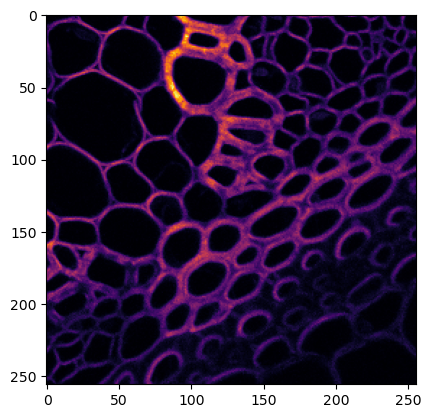

In [43]:
img = next(iter(train_loader))[-1:,:,:,:]
img.shape
plt.imshow(img[0, :,:, 0], 'inferno')

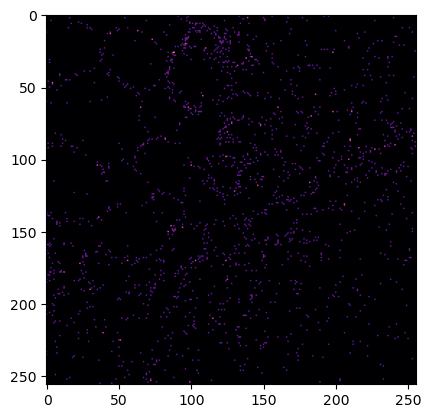

In [45]:
plt.imshow(img[0, :,:, 1:], 'inferno')

In [39]:
img

array([[[[0.02913738, 0.        ],
         [0.05827476, 0.        ],
         [0.08741214, 0.        ],
         ...,
         [1.1654952 , 0.        ],
         [0.8158466 , 0.        ],
         [0.4370607 , 0.        ]],

        [[0.05827476, 0.        ],
         [0.08741214, 0.        ],
         [0.08741214, 0.        ],
         ...,
         [0.52447283, 0.        ],
         [0.2913738 , 0.        ],
         [0.20396166, 1.        ]],

        [[0.11654952, 0.        ],
         [0.05827476, 0.        ],
         [0.05827476, 0.        ],
         ...,
         [0.7284345 , 0.        ],
         [0.67015976, 0.        ],
         [0.4079233 , 0.        ]],

        ...,

        [[0.23309904, 0.        ],
         [0.20396166, 0.        ],
         [0.11654952, 0.        ],
         ...,
         [0.9323962 , 0.        ],
         [0.5536102 , 0.        ],
         [0.4370607 , 0.        ]],

        [[0.34964857, 0.        ],
         [0.2913738 , 0.        ],
         [0.

In [101]:
img[0, :,:, 0].min(), img[0, :,:, 0].max(), img[0, :,:, 0].mean(), img[0, :,:, 0].sum(), img[0, :,:, 1].min(), img[0, :,:, 1].max(), img[0, :,:, 1].mean(), img[0, :,:, 1].sum()

(0.03967034, 10.47297, 1.0, 65536.0, 0.0, 2.0, 0.009185791, 602.0)

In [13]:
from flax.training import checkpoints
# CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/jax/del/'
CHECKPOINT_PATH = "/home/ankith/temp/test/"
if not os.path.exists(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH)
checkpoints.save_checkpoint(ckpt_dir=CHECKPOINT_PATH,
                                    target=trainer.state.params,
                                    step = 0,
                                    overwrite=True)

'/home/ankith/temp/test/checkpoint_0'

In [120]:
img = next(iter(train_loader))
img.shape

/home/ankith/anaconda3/envs/rsenv/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/ankith/anaconda3/envs/rsenv/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(4, 256, 256, 2)

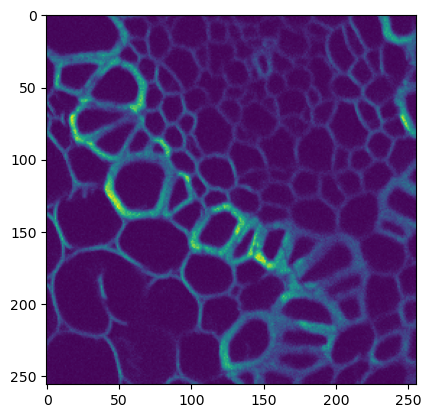

In [38]:
plt.imshow(img[1,:,:,0])

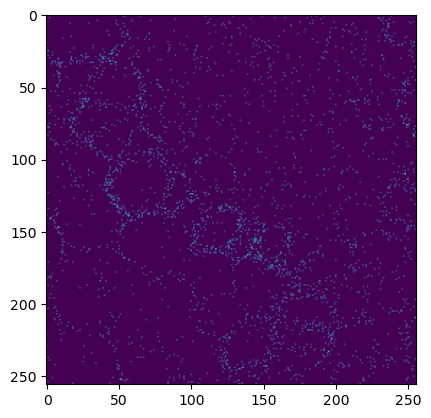

In [39]:
plt.imshow(img[1,:,:,1])

In [48]:
img = np.arange(4 * 32 * 32 * 2).reshape((4, 32, 32 ,2))

In [52]:
img[-1:, :,:,1:].shape

(1, 32, 32, 1)

In [11]:
1e6

1000000.0

In [40]:
img = np.arange(5*32*32*3).reshape((5, 32, 32 ,3))

In [41]:
img.mean(axis = (-1, -2, -3), keepdims= True), img.mean(axis = (-2, -3, -1), keepdims= True)

(array([[[[ 1535.5]]],
 
 
        [[[ 4607.5]]],
 
 
        [[[ 7679.5]]],
 
 
        [[[10751.5]]],
 
 
        [[[13823.5]]]]),
 array([[[[ 1535.5]]],
 
 
        [[[ 4607.5]]],
 
 
        [[[ 7679.5]]],
 
 
        [[[10751.5]]],
 
 
        [[[13823.5]]]]))

In [55]:
def photonLoss(result, target):
        result = torch.from_numpy(result)
        target = torch.from_numpy(target)
        expEnergy = torch.exp(result)
        perImage =  -torch.mean(result*target, dim =(-1,-2,-3), keepdims = True )
        perImage += torch.log(torch.mean(expEnergy, dim =(-1,-2,-3), keepdims = True ))*torch.mean(target, dim =(-1,-2,-3), keepdims = True )
        print(perImage)
        return torch.mean(perImage)

In [96]:
photonLoss(np.array(model.apply(state.params, img[1:2,:,:,:1])), img[1:2,:,:,:1])

tensor([[[[0.0797]]]])


tensor(0.0797)

In [102]:
def photonLossjax(result, target):
        expEnergy = jnp.exp(result)
        perImage =  -jnp.mean(result*target, axis =(-2, -3, -1), keepdims = True )
        perImage += jnp.log(jnp.mean(expEnergy, axis =(-2, -3, -1), keepdims = True ))*jnp.mean(target, axis =(-2, -3, -1), keepdims = True )
        print(perImage)
        return jnp.mean(perImage)

In [124]:
photonLoss(img[0] , img[0]), photonLoss(img , img)

tensor([[[-0.0393]]])
tensor([[[[-0.0393]]],


        [[[-0.3924]]],


        [[[ 0.3594]]],


        [[[ 0.0181]]]])


(tensor(-0.0393), tensor(-0.0136))

In [123]:
photonLossjax(img[0] , img[0]), photonLossjax(img , img)

[[[-0.03930223]]]
[[[[-0.03930223]]]


 [[[-0.3924262 ]]]


 [[[ 0.3593731 ]]]


 [[[ 0.01805222]]]]


(Array(-0.03930223, dtype=float32), Array(-0.01357578, dtype=float32))

In [118]:
img = img

In [130]:
import orbax.checkpoint as obc
from flax.training.train_state import TrainState


TrainState(step=0, apply_fn=<function <lambda> at 0x7f077074c550>, params={}, tx={}, opt_state={})

In [136]:
ckpt = {'model': state}
ckpt

{'model': TrainState(step=0, apply_fn=<bound method Module.apply of UN(
     # attributes
     levels = 10
     channels = 1
     depth = 6
     start_filts = 28
     up_mode = 'transpose'
     merge_mode = 'add'
     dtype = float32
 )>, params={'params': {'down_convs_0': {'DownConv-1': {'kernel': Array([[[[ 1.64187178e-01,  6.47964403e-02, -1.17969319e-01, ...,
            6.42266124e-02, -5.96823208e-02,  4.42593135e-02],
          [ 8.25071186e-02, -5.71502447e-02, -3.69680040e-02, ...,
           -9.35753528e-03, -1.08105578e-01, -5.07452339e-02],
          [ 6.61745593e-02,  2.31828187e-02, -2.14632228e-02, ...,
           -3.76951396e-02,  6.89238962e-03,  3.56388874e-02],
          ...,
          [ 9.61727947e-02,  1.24870144e-01,  1.67595163e-01, ...,
            2.92165461e-03, -2.88299918e-02, -1.66746620e-02],
          [-3.14003713e-02, -3.05169448e-02, -1.62773952e-01, ...,
            5.62926084e-02,  1.06559947e-01, -4.27415781e-03],
          [ 1.55851305e-01, -9.98555

In [139]:
from flax.training import orbax_utils
import orbax

orbax_checkpointer = obc.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('/home/ankith/temp/test/single_save/', ckpt, save_args=save_args)

In [141]:
raw_restored = orbax_checkpointer.restore('/home/ankith/temp/test/single_save/')
raw_restored

: 